#Import Libraries

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from keras.regularizers import l1
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
from keras.layers import Dropout
from sklearn.cluster import KMeans

#Generating Sample Data

In [ ]:

def generate_sample_data():

  # Constants based on the operational data provided and re-initializing num_rows
  np.random.seed(0)  # For reproducibility
  num_rows = 20000

  # Generating data with updated packet_size generation
  data = {
      "PV_Voltage": np.random.uniform(2.18, 17.63, num_rows),
      "PV_Current": np.random.uniform(0.07, 0.83, num_rows),
      "Battery_Voltage": np.random.uniform(12.97, 13.4, num_rows),
      "Battery_Current": np.random.uniform(-0.41, 0.86, num_rows),
      "SOC": np.random.uniform(20, 100, num_rows),  # Assuming SOC range
      "PCC_Voltage": np.random.uniform(23.06, 23.92, num_rows),
      "PCC_Current": np.random.uniform(0.05, 0.26, num_rows),
      "Three_Phase_Voltage": np.random.uniform(14.54, 16.12, num_rows),
      "Three_Phase_Current": np.random.uniform(-0.11, 0.17, num_rows),
      "timestamp": pd.date_range(start="2024-02-15", periods=num_rows, freq='T').strftime('%Y-%m-%d %H:%M:%S'),
      "result_code": np.random.choice([200, 400, 500], num_rows, p=[0.95, 0.03, 0.02]),  # Assuming probabilities for result codes
      "Mqtt_Topic": np.random.choice(["pv_voltage", "pv_current", "battery_voltage", "battery_current",
                                      "SOC", "pcc_voltage", "pcc_current", "three_p_voltage", "three_p_current"], num_rows),
      "qos": np.random.choice([0, 1, 2], num_rows, p=[0.5, 0.3, 0.2]),  # Assuming QoS distribution
      "ip_address": np.random.choice(["192.168.1.100", "192.168.1.101", "192.168.1.102"], num_rows, p=[0.4, 0.3, 0.3]),
      "port": np.random.choice([1883, 8883], num_rows, p=[0.7, 0.3]),  # Standard MQTT ports
      "authentication": np.random.choice(["None", "Basic", "Token"], num_rows, p=[0.1, 0.45, 0.45]),
      "data_transmission_frequency": np.random.choice(["1Hz", "2Hz", "5Hz"], num_rows, p=[0.3, 0.4, 0.3]),
      "packet_size": np.round(np.random.uniform(50, 1500, num_rows), 2)  # Updated packet size generation
  }
  return data

# Creating the DataFrame with the updated data

df = pd.DataFrame(generate_sample_data())
df=pd

df.head()


,PV_Voltage,PV_Current,Battery_Voltage,Battery_Current,SOC,PCC_Voltage,PCC_Current,Three_Phase_Voltage,Three_Phase_Current,timestamp,result_code,Mqtt_Topic,qos,ip_address,port,authentication,data_transmission_frequency,packet_size
0,10.659169,0.368051,13.128780,0.768503,20.887740,23.520321,0.180977,14.662604,-0.058622,2024-02-15 00:00:00,400,three_p_current,0,192.168.1.101,1883,Token,2Hz,311.50
1,13.229676,0.101279,13.060870,0.736730,20.141583,23.837478,0.078650,15.797855,0.088366,2024-02-15 00:01:00,400,battery_current,2,192.168.1.100,8883,Basic,1Hz,862.08
2,11.492694,0.771708,13.175069,0.133073,32.404410,23.492061,0.237653,15.306850,-0.005597,2024-02-15 00:02:00,200,SOC,0,192.168.1.101,1883,Token,2Hz,1340.08
3,10.598445,0.378739,13.005361,0.238723,45.340892,23.146748,0.116796,15.859013,0.008864,2024-02-15 00:03:00,200,three_p_voltage,0,192.168.1.100,8883,Basic,2Hz,624.83
4,8.725467,0.787654,13.072194,0.330664,72.147591,23.513721,0.171592,15.367052,-0.035593,2024-02-15 00:04:00,200,SOC,0,192.168.1.100,1883,Token,1Hz,327.81


In [ ]:
df.describe()

,PV_Voltage,PV_Current,Battery_Voltage,Battery_Current,SOC,PCC_Voltage,PCC_Current,Three_Phase_Voltage,Three_Phase_Current,result_code,qos,port,packet_size
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,9.840871,0.449593,13.184713,0.225586,60.191456,23.493008,0.155244,15.329372,0.031077,212.395000,0.697300,3977.400000,770.636678
std,4.487450,0.219158,0.123907,0.367332,23.117076,0.249501,0.060611,0.454430,0.080538,54.405992,0.777305,3205.433259,416.725193
min,2.181119,0.070262,12.970085,-0.409920,20.000265,23.060025,0.050004,14.540111,-0.109996,200.000000,0.000000,1883.000000,50.070000
25%,5.951800,0.258994,13.076415,-0.096090,40.222469,23.276215,0.102547,14.938742,-0.038640,200.000000,0.000000,1883.000000,410.232500
50%,9.803203,0.450720,13.186265,0.222505,60.230362,23.495209,0.155556,15.329854,0.031930,200.000000,1.000000,1883.000000,766.595000
75%,13.749942,0.639097,13.291921,0.544054,80.200881,23.710843,0.207600,15.723406,0.101583,200.000000,1.000000,8883.000000,1129.572500
max,17.629659,0.829938,13.399986,0.859949,99.996600,23.919990,0.259995,16.119895,0.169995,500.000000,2.000000,8883.000000,1499.990000


In [ ]:
df.info()
df.to_csv('data1.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PV_Voltage                   20000 non-null  float64
 1   PV_Current                   20000 non-null  float64
 2   Battery_Voltage              20000 non-null  float64
 3   Battery_Current              20000 non-null  float64
 4   SOC                          20000 non-null  float64
 5   PCC_Voltage                  20000 non-null  float64
 6   PCC_Current                  20000 non-null  float64
 7   Three_Phase_Voltage          20000 non-null  float64
 8   Three_Phase_Current          20000 non-null  float64
 9   timestamp                    20000 non-null  object 
 10  result_code                  20000 non-null  int64  
 11  Mqtt_Topic                   20000 non-null  object 
 12  qos                          20000 non-null  int64  
 13  ip_address      

In [ ]:
df.to_csv('data.csv')

#Encoding, Scaling and Feature Selection

In [ ]:

label_encoders = {}
for column in ['Mqtt_Topic', 'ip_address', 'authentication', 'data_transmission_frequency']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Select features for the model
features = ['PV_Voltage', 'PV_Current', 'Battery_Voltage', 'Battery_Current',
            'PCC_Voltage', 'PCC_Current', 'Three_Phase_Voltage', 'Three_Phase_Current',
            'Mqtt_Topic', 'ip_address', 'authentication', 'data_transmission_frequency', 'packet_size']

# Normalize numerical features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])






In [ ]:
df[features].to_csv('sample.csv')

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test = train_test_split(df[features], test_size=0.2, random_state=42)

#Isolation Forest

In [ ]:


# Initialize and train the Isolation Forest model
iso_forest = IsolationForest(n_estimators=200, max_samples='auto', contamination=float(0.05), random_state=42)
iso_forest.fit(X_train)

# Predict anomalies on the training data
y_pred_train_iso = iso_forest.predict(X_train)
# Predict anomalies on the testing data
y_pred_test_iso = iso_forest.predict(X_test)

# Evaluate the model's effectiveness
# Since we're not using direct labels, we'll inspect the anomaly scores instead
anomaly_scores_train_iso = iso_forest.decision_function(X_train)
anomaly_scores_test_iso = iso_forest.decision_function(X_test)


#print([(i,j) for i,j in zip(anomaly_scores_train_iso,anomaly_scores_test_iso)])

# Output some of the prediction results and anomaly scores for inspection



#iso_forest.base_estimator_,
#iso_forest.estimators_,
#iso_forest.estimators_features_,
#iso_forest.feature_names_in_
#iso_forest.score_samples(X_train)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


[(0.06297420348865868, 0.037054069831195635), (0.03561633155976873, 0.06413842405811288), (0.0588706077733, 0.042560266481023734), (0.037714947722329084, 0.012670363163259313), (0.04102589255042843, 0.05305569870226501), (0.04912709318741737, 0.07227074628575897), (0.011342646530236533, 0.07197277498097954), (0.03632831991643548, 0.05010264621426985), (0.034977819565862656, 0.029108401762927616), (0.0085036621874095, -0.014253494320685567), (0.05878721533463993, 0.073889724322735), (0.06368226619845585, 0.02690493805477112), (0.02461034646472804, -0.010793292620999706), (0.02822892535968824, 0.04572618903204184), (0.009137062561978881, 0.036882410050630865), (0.055313962982573295, 0.038061264159671926), (0.05375802365808491, 0.06836113150218615), (0.05909832361442924, 0.07326189315519821), (0.058263440418947376, 0.05761135677004059), (0.03297326675407242, -0.011497158193309542), (-0.0018906740229963637, -0.0001512355232609064), (0.020123767070897358, 0.040596343272655044), (0.060870345

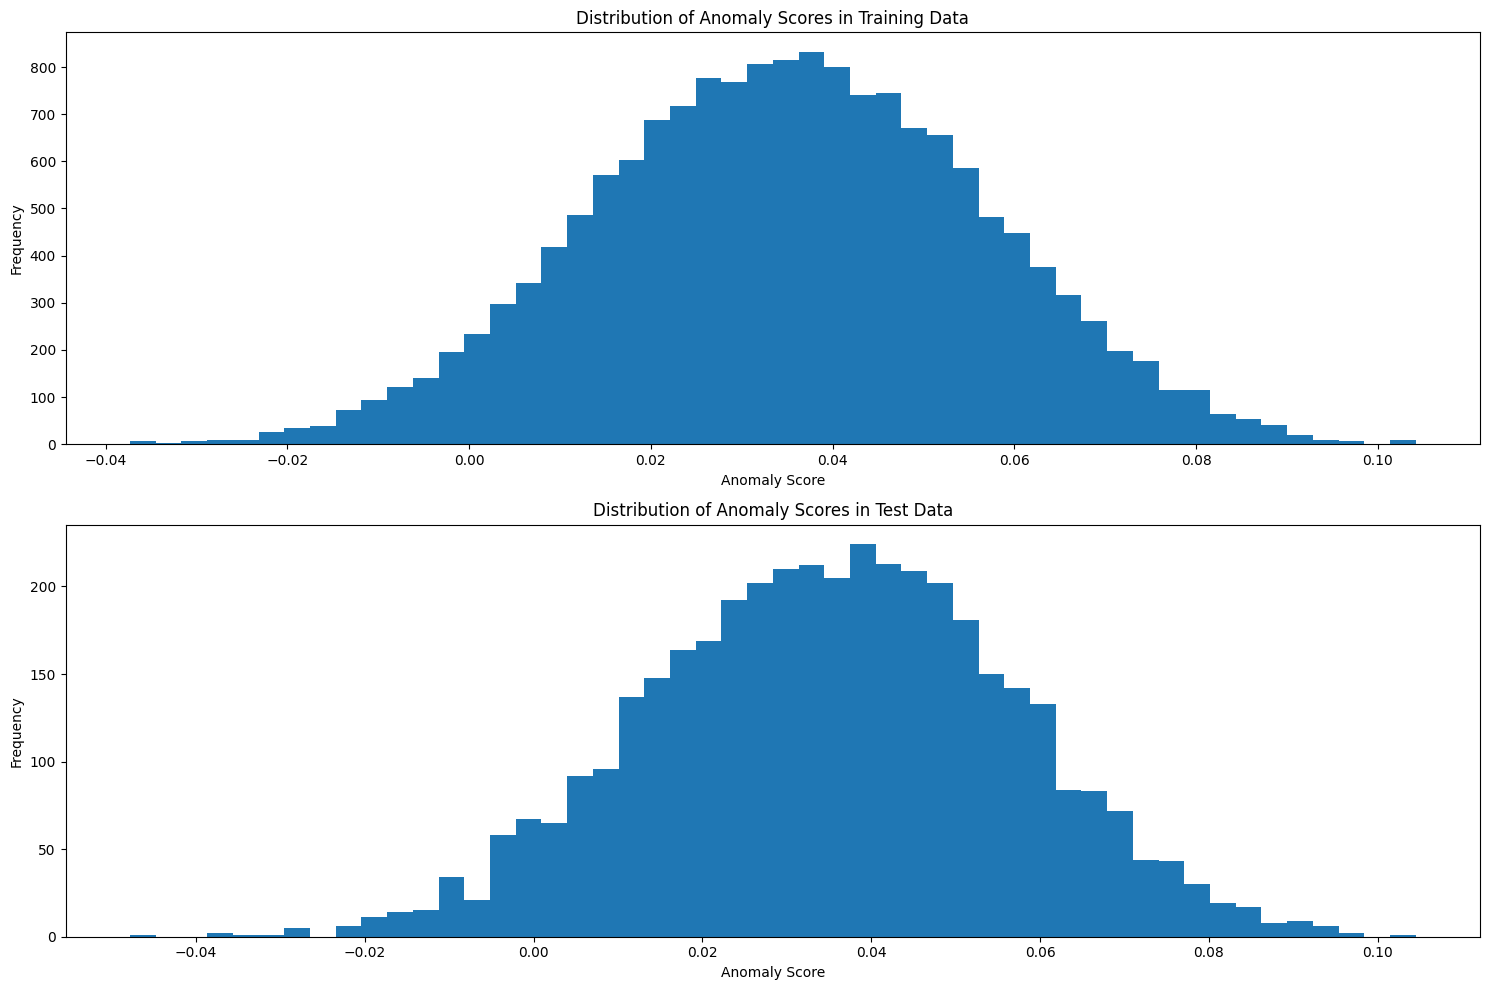

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the distribution of anomaly scores
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.hist(anomaly_scores_train_iso, bins=50)
plt.title('Distribution of Anomaly Scores in Training Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
plt.hist(anomaly_scores_test_iso, bins=50)
plt.title('Distribution of Anomaly Scores in Test Data')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#Autoencoder

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l1_l2

input_dim = X_train.shape[1]  # Feature dimensions
encoding_dim = 128  # Size of the encoding layer

# Define the encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(256, activation="relu", activity_regularizer=l1_l2(l1=10e-5, l2=10e-4))(input_layer)
encoder = Dense(128, activation="relu")(encoder)
encoder = Dense(encoding_dim, activation='relu')(encoder)

# Define the decoder
decoder = Dense(128, activation='relu')(encoder)
decoder = Dense(256, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='relu')(decoder)

# Compile the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(X_train, X_train, batch_size=256, epochs=100, shuffle=True, validation_split=0.2, verbose=1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 256)               3584      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 13)                3341  

In [ ]:
import numpy as np

# Predict the reconstructed features from the autoencoder for the test data
pred_train_autoencoder = autoencoder.predict(X_train)

pred_test_autoencoder = autoencoder.predict(X_test)

# Calculate the MSE reconstruction loss for each sample in the test set
mse_train_autoencoder= np.mean(np.power(X_train - pred_train_autoencoder, 2), axis=1)
mse_test_autoencoder = np.mean(np.power(X_test - pred_test_autoencoder, 2), axis=1)
print(mse_test_autoencoder.count())

# Determine the threshold as the 95th percentile of the test MSE
threshold_autoencoder = np.quantile(mse_train_autoencoder, 0.95)  # Note: using training set to establish threshold



# Classify each test sample as 'Good' or 'Bad' based on whether its MSE exceeds the threshold
train_labels_autoencoder = ['Good' if mse <= threshold_autoencoder else 'Bad' for mse in mse_train_autoencoder]
test_labels_autoencoder = ['Good' if mse <= threshold_autoencoder else 'Bad' for mse in mse_test_autoencoder]



125/125 [==============================] - 0s 2ms/step
4000


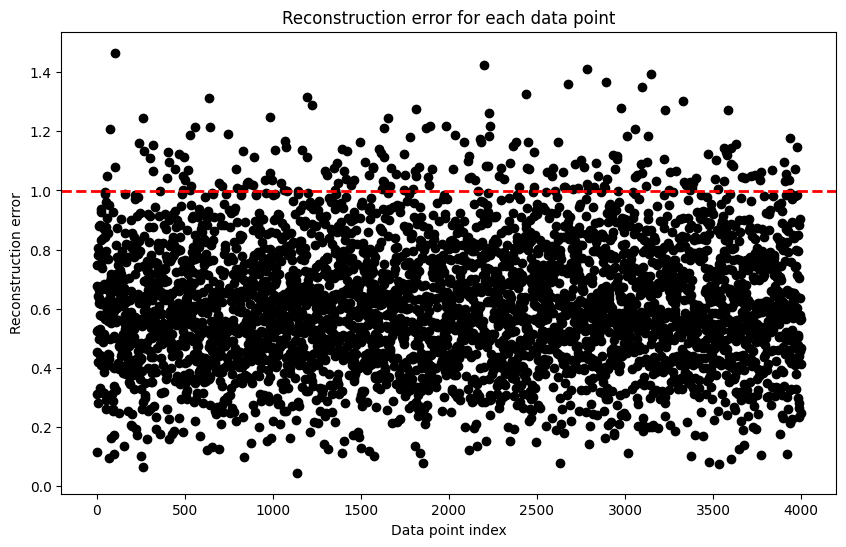

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(mse_test_autoencoder)), mse_test_autoencoder, color='k')
plt.axhline(threshold_autoencoder, color='r', linestyle='dashed', linewidth=2)
plt.title('Reconstruction error for each data point')
plt.xlabel('Data point index')
plt.ylabel('Reconstruction error')
plt.show()


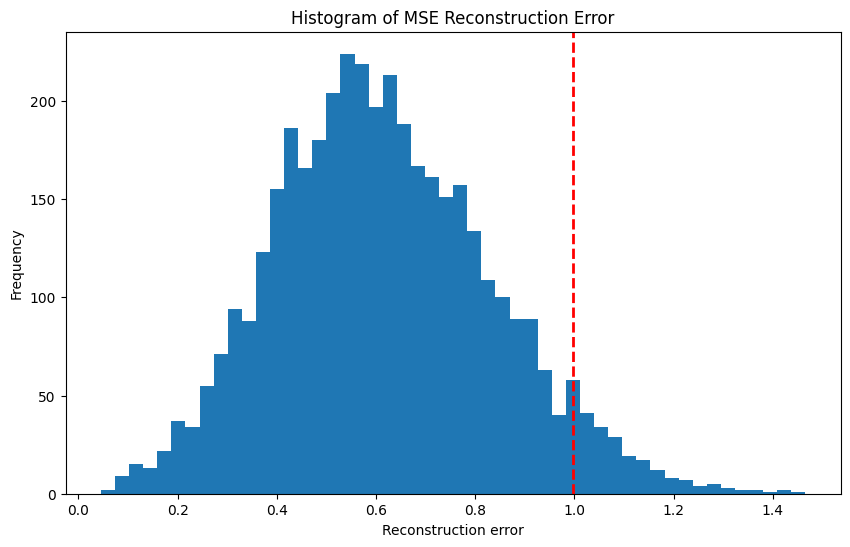

In [ ]:


plt.figure(figsize=(10, 6))
plt.hist(mse_test_autoencoder, bins=50)
plt.axvline(threshold_autoencoder, color='r', linestyle='dashed', linewidth=2)
plt.title('Histogram of MSE Reconstruction Error')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Iterate through the autoencoder layers to find the first Dense layer
for layer in autoencoder.layers:
    if 'dense' in layer.name:  # Adjust this condition based on your layer naming
        encoder_weights = layer.get_weights()[0]
        break  # Break after finding the first Dense layer

# Now calculate the feature importance as done before
feature_importance = np.sum(np.abs(encoder_weights), axis=1)
feature_importance_dict = dict(zip(features, feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print sorted feature importance
print("Feature Importance in Descending Order:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")


Feature Importance in Descending Order:
packet_size: 19.262001037597656
data_transmission_frequency: 18.32735824584961
Battery_Voltage: 17.85881805419922
Three_Phase_Current: 17.58716583251953
PCC_Voltage: 17.47867202758789
PV_Current: 17.29727554321289
Mqtt_Topic: 17.121356964111328
authentication: 17.05722427368164
PCC_Current: 16.08839988708496
ip_address: 15.412004470825195
Battery_Current: 15.200851440429688
Three_Phase_Voltage: 14.704113006591797
PV_Voltage: 14.417827606201172


#Varitional Autoencoder

In [ ]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

# VAE sample layer
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Network parameters

input_shape = (input_dim, )
intermediate_dim = 512
latent_dim = 2

# Encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = binary_crossentropy(inputs, outputs) * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

# Train the VAE

vae.fit(X_train, X_train, epochs=50, batch_size=256, validation_split=0.2)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 13)]                 0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 512)                  7168      ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['dense_6[0][0]']             
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['dense_6[0][0]']             
                                                                                            

In [ ]:
pred_train_var = vae.predict(X_train)
pred_test_var = vae.predict(X_test)
mse_train_var = np.mean(np.power(X_train - pred_train_var, 2), axis=1)
mse_test_var = np.mean(np.power(X_test - pred_test_var, 2), axis=1)

# Determine the threshold as the 95th percentile of the test MSE
threshold_var = np.quantile(mse_train_var, 0.95)  # Note: using training set to establish threshold



# Classify each test sample as 'Good' or 'Bad' based on whether its MSE exceeds the threshold
train_labels_var = ['Good' if mse <= threshold_var else 'Bad' for mse in mse_train_var]
test_labels_var = ['Good' if mse <= threshold_var else 'Bad' for mse in mse_test_var]



125/125 [==============================] - 0s 4ms/step


#one class svm


In [ ]:
from sklearn.svm import OneClassSVM

# Initialize the model
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)

# Fit the model
oc_svm.fit(X_train)

# Predict anomalies (1 for normal, -1 for anomaly)
y_pred_train_svm = oc_svm.predict(X_train)
y_pred_test_svm = oc_svm.predict(X_test)

# Retrieve the scores (the distance of each sample from the hyperplane)
anomaly_scores_train_svm = oc_svm.score_samples(X_train)
anomaly_scores_test_svm = oc_svm.score_samples(X_test)

y_pred_train_svm, y_pred_test_svm


(array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]))

#Comparsion of algorithms

In [ ]:


# Convert the numpy arrays back to dataframes for easier manipulation
X_train_iso = pd.DataFrame(X_train, columns=features)
X_test_iso = pd.DataFrame(X_test, columns=features)


# Add the anomaly scores as new columns
X_train_iso['Anomaly_Score'] = anomaly_scores_train_iso
X_test_iso['Anomaly_Score'] = anomaly_scores_test_iso

threshold = np.percentile(anomaly_scores_train_iso, 5)
print(threshold)

# Additionally, classify based on threshold if you prefer that over default labels
train_labels = ['Bad' if score < threshold else 'Good' for score in anomaly_scores_train_iso]
test_labels = ['Bad' if score < threshold else 'Good' for score in anomaly_scores_test_iso]

# Now, X_train_df and X_test_df have two new columns: 'Anomaly_Score' and 'Status'
# Let's print out the first few rows of each to inspect
X_train_iso['Label'] = train_labels
X_test_iso['Label'] = test_labels

X_train_iso[X_train_iso['Label']=='Bad']

X_test_iso[X_test_iso['Label']=='Bad']



-4.94707475261506e-17


,PV_Voltage,PV_Current,Battery_Voltage,Battery_Current,PCC_Voltage,PCC_Current,Three_Phase_Voltage,Three_Phase_Current,Mqtt_Topic,ip_address,authentication,data_transmission_frequency,packet_size,Anomaly_Score,Label
8115,1.215807,-0.748591,0.298344,0.767937,1.333214,1.369799,1.289798,-1.737040,1.524668,1.325475,-1.049117,-1.305573,1.549389,-0.014253,Bad
16441,-0.053457,-1.263107,-1.549860,-0.204545,-1.726263,1.213333,-0.469113,0.802952,1.137795,-1.087990,0.004108,-1.305573,1.739975,-0.010793,Bad
322,-1.516565,-1.686947,0.380180,0.011963,-1.550844,1.668935,1.206718,-0.941429,1.137795,1.325475,1.057332,-0.018533,1.436890,-0.011497,Bad
9923,-0.144195,-0.596653,-1.511171,1.510237,1.424880,0.847744,1.507939,-1.125013,0.364048,1.325475,0.004108,-1.305573,1.016915,-0.000151,Bad
16675,1.681955,-0.313244,1.470724,-1.291885,0.429826,1.401486,1.611483,-1.633018,-0.409699,-1.087990,1.057332,-1.305573,1.142228,-0.001517,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14720,-0.452238,-1.482857,-1.239043,1.301823,-1.388201,1.611331,-1.597876,0.197158,0.364048,1.325475,0.004108,1.268507,1.516273,-0.021801,Bad
12314,1.494048,-0.075864,-1.041284,0.602622,1.515723,1.469797,-1.631487,1.646135,0.750921,-1.087990,1.057332,-1.305573,-1.624173,-0.003754,Bad
3615,-1.015777,1.442656,-0.992550,-1.303136,-0.072987,-1.731573,-0.192699,-0.860011,-1.183446,1.325475,1.057332,1.268507,1.535063,-0.009772,Bad
449,1.408537,-1.720180,-1.610692,1.270640,0.673050,-1.103780,-1.124034,1.499997,-0.796572,1.325475,-1.049117,-1.305573,-0.839247,-0.010568,Bad


In [ ]:
# Convert the numpy arrays back to dataframes for easier manipulation
X_train_svm = pd.DataFrame(X_train, columns=features)
X_test_svm = pd.DataFrame(X_test, columns=features)


# Add the anomaly scores as new columns
X_train_svm['Anomaly_Score'] = y_pred_train_svm
X_test_svm['Anomaly_Score'] = y_pred_test_svm


# Additionally, classify based on threshold if you prefer that over default labels
train_labels_svm = ['Bad' if score==-1 else 'Good' for score in y_pred_train_svm]
test_labels_svm = ['Bad' if score==-1 else 'Good' for score in y_pred_test_svm]

# Now, X_train_df and X_test_df have two new columns: 'Anomaly_Score' and 'Status'
# Let's print out the first few rows of each to inspect
X_train_svm['Label'] = train_labels_svm
X_test_svm['Label'] = test_labels_svm

X_train_svm[X_train_svm['Label']=='Bad']

X_test_svm[X_test_svm['Label']=='Bad']



,PV_Voltage,PV_Current,Battery_Voltage,Battery_Current,PCC_Voltage,PCC_Current,Three_Phase_Voltage,Three_Phase_Current,Mqtt_Topic,ip_address,authentication,data_transmission_frequency,packet_size,Anomaly_Score,Label
8115,1.215807,-0.748591,0.298344,0.767937,1.333214,1.369799,1.289798,-1.737040,1.524668,1.325475,-1.049117,-1.305573,1.549389,-1,Bad
322,-1.516565,-1.686947,0.380180,0.011963,-1.550844,1.668935,1.206718,-0.941429,1.137795,1.325475,1.057332,-0.018533,1.436890,-1,Bad
16675,1.681955,-0.313244,1.470724,-1.291885,0.429826,1.401486,1.611483,-1.633018,-0.409699,-1.087990,1.057332,-1.305573,1.142228,-1,Bad
12157,1.452297,-0.949294,-1.395010,1.723005,-1.277871,1.151718,1.642602,0.766985,1.524668,0.118742,0.004108,-1.305573,-1.288667,-1,Bad
3669,0.976240,-1.381535,1.506141,-1.146623,-0.770117,-1.678136,0.998301,-1.118112,0.364048,1.325475,-1.049117,1.268507,-1.429867,-1,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7178,1.466237,-1.676619,1.082027,-1.729816,-1.696259,-0.935037,0.275327,-0.632864,1.137795,1.325475,1.057332,1.268507,-0.845174,-1,Bad
14720,-0.452238,-1.482857,-1.239043,1.301823,-1.388201,1.611331,-1.597876,0.197158,0.364048,1.325475,0.004108,1.268507,1.516273,-1,Bad
12314,1.494048,-0.075864,-1.041284,0.602622,1.515723,1.469797,-1.631487,1.646135,0.750921,-1.087990,1.057332,-1.305573,-1.624173,-1,Bad
449,1.408537,-1.720180,-1.610692,1.270640,0.673050,-1.103780,-1.124034,1.499997,-0.796572,1.325475,-1.049117,-1.305573,-0.839247,-1,Bad


In [ ]:
X_train_autoencoder = pd.DataFrame(X_train, columns=features)
X_test_autoencoder = pd.DataFrame(X_test, columns=features)


X_train_autoencoder['Label'] = train_labels_autoencoder
X_test_autoencoder['Label'] = test_labels_autoencoder

X_train_autoencoder[X_train_autoencoder['Label']=='Bad']
X_test_autoencoder[X_test_autoencoder['Label']=='Bad']

,PV_Voltage,PV_Current,Battery_Voltage,Battery_Current,PCC_Voltage,PCC_Current,Three_Phase_Voltage,Three_Phase_Current,Mqtt_Topic,ip_address,authentication,data_transmission_frequency,packet_size,Label
17059,-1.291135,-1.214670,0.505685,1.668682,-1.248684,-1.579854,0.062652,1.461256,-1.570319,-1.087990,-1.049117,-1.305573,1.164354,Bad
7713,-1.366547,-1.702472,-0.372075,0.215222,-1.619530,-0.964539,0.541555,-1.720448,0.364048,-1.087990,-1.049117,-1.305573,-0.403865,Bad
4770,-1.666545,-1.685014,-0.503526,-0.543532,0.698980,-1.186161,-1.392218,-1.730912,1.137795,-1.087990,1.057332,-1.305573,-1.536967,Bad
16615,0.048201,-1.341251,0.354256,-1.252515,-1.352729,-0.327759,-0.690486,1.686973,-1.183446,1.325475,-1.049117,-1.305573,-1.514817,Bad
10645,-1.520310,-1.565863,0.767146,-1.275695,-1.153091,-1.493330,-0.932511,0.897469,-1.570319,-1.087990,1.057332,1.268507,-0.780982,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7178,1.466237,-1.676619,1.082027,-1.729816,-1.696259,-0.935037,0.275327,-0.632864,1.137795,1.325475,1.057332,1.268507,-0.845174,Bad
9000,0.484936,-0.405721,-1.725781,-0.333408,-0.700136,-1.568472,0.428055,-0.283077,1.524668,-1.087990,-1.049117,-1.305573,-0.918246,Bad
9451,-1.555252,-0.537797,-0.700811,-1.583256,-0.176245,-1.397193,-1.716556,0.281268,-0.796572,-1.087990,1.057332,-1.305573,-1.070052,Bad
449,1.408537,-1.720180,-1.610692,1.270640,0.673050,-1.103780,-1.124034,1.499997,-0.796572,1.325475,-1.049117,-1.305573,-0.839247,Bad


In [ ]:
X_train_var = pd.DataFrame(X_train, columns=features)
X_test_var = pd.DataFrame(X_test, columns=features)


X_train_var['Label'] = train_labels_var
X_test_var['Label'] = test_labels_var

X_train_var[X_train_var['Label']=='Bad']
X_test_var[X_test_var['Label']=='Bad']

,PV_Voltage,PV_Current,Battery_Voltage,Battery_Current,PCC_Voltage,PCC_Current,Three_Phase_Voltage,Three_Phase_Current,Mqtt_Topic,ip_address,authentication,data_transmission_frequency,packet_size,Label
3669,0.976240,-1.381535,1.506141,-1.146623,-0.770117,-1.678136,0.998301,-1.118112,0.364048,1.325475,-1.049117,1.268507,-1.429867,Bad
4058,1.042442,1.708082,1.161223,-0.316444,-0.599808,-0.733850,-1.644945,-0.413441,1.524668,-1.087990,-1.049117,1.268507,1.664360,Bad
15782,-1.190556,-0.586791,1.556260,0.833519,0.928914,1.703520,-0.271875,-0.217710,-1.183446,1.325475,-1.049117,1.268507,-1.275997,Bad
17059,-1.291135,-1.214670,0.505685,1.668682,-1.248684,-1.579854,0.062652,1.461256,-1.570319,-1.087990,-1.049117,-1.305573,1.164354,Bad
7567,-0.786400,1.065878,0.520453,-1.721560,1.501895,1.285983,0.539034,1.340290,-1.570319,1.325475,1.057332,1.268507,0.397810,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9161,-1.674796,-0.027272,1.126886,1.340883,-1.299119,-1.397736,-1.639551,-1.279522,-0.796572,1.325475,-1.049117,1.268507,1.362763,Bad
7178,1.466237,-1.676619,1.082027,-1.729816,-1.696259,-0.935037,0.275327,-0.632864,1.137795,1.325475,1.057332,1.268507,-0.845174,Bad
14720,-0.452238,-1.482857,-1.239043,1.301823,-1.388201,1.611331,-1.597876,0.197158,0.364048,1.325475,0.004108,1.268507,1.516273,Bad
12314,1.494048,-0.075864,-1.041284,0.602622,1.515723,1.469797,-1.631487,1.646135,0.750921,-1.087990,1.057332,-1.305573,-1.624173,Bad


In [ ]:
# Overlap of anomalies detected
common_bad = set(X_test_iso[X_test_iso['Label'] == 'Bad'].index) & \
             set(X_test_svm[X_test_svm['Label'] == 'Bad'].index) & \
             set(X_test_autoencoder[X_test_autoencoder['Label'] == 'Bad'].index) & \
             set(X_test_var[X_test_var['Label'] == 'Bad'].index)

print(len(common_bad))
overlap_rate = len(common_bad) / X_test.shape[0]  # Assuming X_test is your test dataset
print(f"Overlap rate of detected anomalies across all models: {overlap_rate:.2%}")


47
Overlap rate of detected anomalies across all models: 1.18%


In [ ]:
import pandas as pd
import numpy as np

# Assuming X_train and X_test have been defined as per your dataset

# Labels assigned by each model
labels_train = {
    'Isolation_Forest': train_labels,
    'One_Class_SVM': train_labels_svm,
    'Autoencoder': train_labels_autoencoder,                             # Labels from Autoencoder
    'Variational_Autoencoder': train_labels_var                          # Labels from Variational Autoencoder
}


# Convert labels to a DataFrame
labels_df_train = pd.DataFrame(labels_train, index=X_train.index)

# Initialize the agreement matrix
agreement_matrix_train = pd.DataFrame(np.zeros((4, 4)), index=labels_train.keys(), columns=labels_train.keys())

# Calculate the agreement between each pair of models
for model1 in labels_train.keys():
    for model2 in labels_train.keys():
        agreement = np.mean(labels_df_train[model1] == labels_df_train[model2])
        agreement_matrix_train.loc[model1, model2] = agreement

# Print the agreement matrix
print(agreement_matrix_train)


                         Isolation_Forest  One_Class_SVM  Autoencoder  \
Isolation_Forest                 1.000000       0.967313     0.935375   
One_Class_SVM                    0.967313       1.000000     0.935312   
Autoencoder                      0.935375       0.935312     1.000000   
Variational_Autoencoder          0.959000       0.972437     0.933625   

                         Variational_Autoencoder  
Isolation_Forest                        0.959000  
One_Class_SVM                           0.972437  
Autoencoder                             0.933625  
Variational_Autoencoder                 1.000000  


In [ ]:
import pandas as pd
import numpy as np

# Assuming X_train and X_test have been defined as per your dataset

# Labels assigned by each model
labels_test = {
    'Isolation_Forest': test_labels,
    'One_Class_SVM': test_labels_svm,
    'Autoencoder': test_labels_autoencoder,                             # Labels from Autoencoder
    'Variational_Autoencoder': test_labels_var                          # Labels from Variational Autoencoder
}


# Convert labels to a DataFrame
labels_df_test = pd.DataFrame(labels_test, index=X_test.index)

# Initialize the agreement matrix
agreement_matrix_test = pd.DataFrame(np.zeros((4, 4)), index=labels_test.keys(), columns=labels_test.keys())

# Calculate the agreement between each pair of models
for model1 in labels_test.keys():
    for model2 in labels_test.keys():
        agreement = np.mean(labels_df_test[model1] == labels_df_test[model2])
        agreement_matrix_test.loc[model1, model2] = agreement

# Print the agreement matrix
print(agreement_matrix_test)


                         Isolation_Forest  One_Class_SVM  Autoencoder  \
Isolation_Forest                  1.00000        0.96550      0.92650   
One_Class_SVM                     0.96550        1.00000      0.93000   
Autoencoder                       0.92650        0.93000      1.00000   
Variational_Autoencoder           0.95425        0.97075      0.93225   

                         Variational_Autoencoder  
Isolation_Forest                         0.95425  
One_Class_SVM                            0.97075  
Autoencoder                              0.93225  
Variational_Autoencoder                  1.00000  


#DBSCAN

min_samples 26


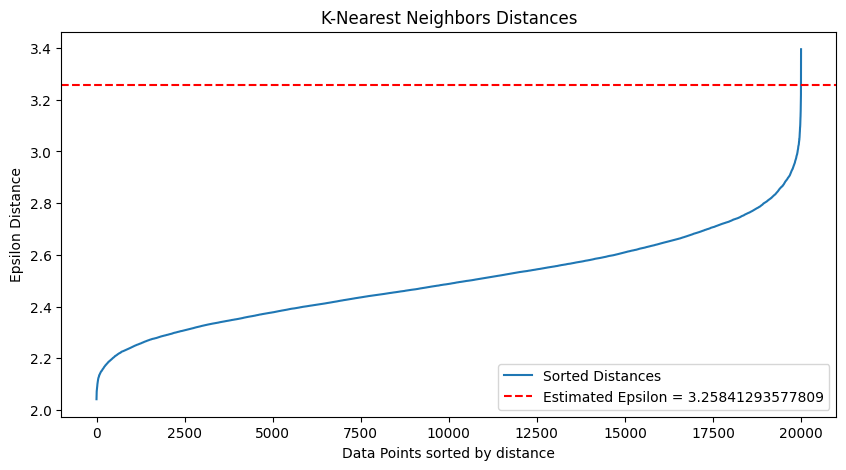

Estimated Epsilon: 3.25841293577809


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Dynamic calculation of min_samples
num_features = df[features].shape[1]  # Number of features
min_samples = 2 * num_features  # Common heuristic
print("min_samples", min_samples)

# Assuming df and features are defined, and min_samples is set
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(df[features])
distances, indices = neighbors_fit.kneighbors(df[features])

# Sort the distances
sorted_distances = np.sort(distances, axis=0)
sorted_distances = sorted_distances[:, min_samples - 1]  # Now dynamically using min_samples

# Function to estimate epsilon using the maximum curvature method (elbow method)
def estimate_epsilon(sorted_distances):
    # Calculate the derivative of the distances
    gradient = np.diff(sorted_distances, axis=0)
    # Calculate the second derivative of the distances
    curvature = np.diff(gradient, axis=0)
    # The index of the maximum curvature is considered the elbow point
    epsilon_index = np.argmax(curvature)
    # Return the epsilon value corresponding to the elbow point
    return sorted_distances[epsilon_index + 1]  # +1 due to the nature of the diff reducing the array length

# Estimate epsilon
estimated_epsilon = estimate_epsilon(sorted_distances)

# Plotting the result for visual confirmation
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances, label='Sorted Distances')
plt.axhline(y=estimated_epsilon, color='r', linestyle='--', label=f'Estimated Epsilon = {estimated_epsilon}')
plt.title("K-Nearest Neighbors Distances")
plt.xlabel("Data Points sorted by distance")
plt.ylabel("Epsilon Distance")
plt.legend()
plt.show()

print(f"Estimated Epsilon: {estimated_epsilon}")



{0}


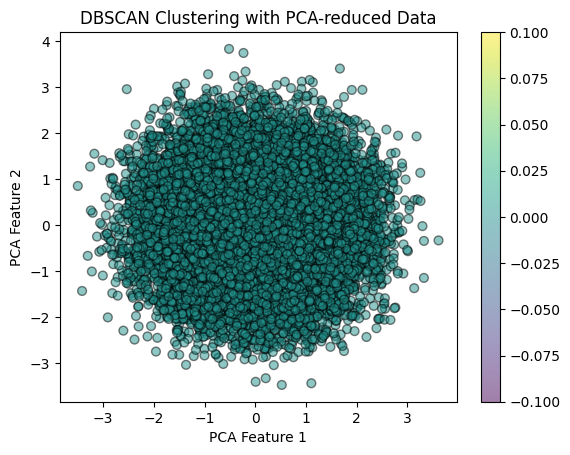

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Apply DBSCAN with the new eps value (assume you've chosen one based on the plot)
dbscan = DBSCAN(eps=estimated_epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(df[features])
print(set(clusters))

# PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)  # Reduce to 2 components for 2D visualization
reduced_data = pca.fit_transform(df[features])

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', marker='o',
            edgecolor='k', s=40, alpha=0.5)
plt.title('DBSCAN Clustering with PCA-reduced Data')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar()
plt.show()


In [ ]:
# Refine the range of eps values and min_samples for a quicker analysis
refined_eps_values = np.linspace(estimated_epsilon * 0.9, estimated_epsilon * 1.1, num=3)  # Reduced range and number
refined_min_samples_values = range(num_features, num_features * 2, 4)  # Less granular steps

# Reduced dictionary for refined results
refined_clustering_results = {}

# Run DBSCAN for the refined ranges
for eps in refined_eps_values:
    for min_samples in refined_min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(df[features])
        # Count the number of clusters and noise points
        num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        noise_points = list(clusters).count(-1)
        # Save the results for these parameters
        refined_clustering_results[(eps, min_samples)] = (num_clusters, noise_points)

# Output the refined results
refined_clustering_results


{(2.932571642200281, 13): (1, 0),
 (2.932571642200281, 17): (1, 0),
 (2.932571642200281, 21): (1, 0),
 (2.932571642200281, 25): (1, 0),
 (3.2584129357780904, 13): (1, 0),
 (3.2584129357780904, 17): (1, 0),
 (3.2584129357780904, 21): (1, 0),
 (3.2584129357780904, 25): (1, 0),
 (3.584254229355899, 13): (1, 0),
 (3.584254229355899, 17): (1, 0),
 (3.584254229355899, 21): (1, 0),
 (3.584254229355899, 25): (1, 0)}

#Hirearchical Clustering

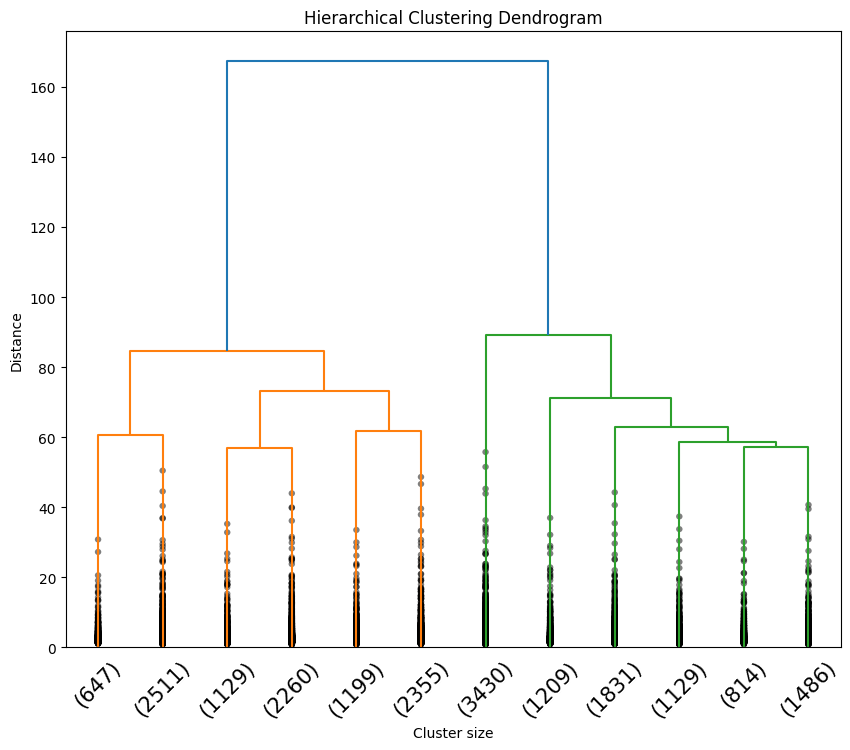

In [ ]:

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# Perform Hierarchical Clustering
Z = linkage(df[features], 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


In [ ]:
from scipy.cluster.hierarchy import fcluster

# The range of potential cluster numbers to evaluate
cluster_range = range(2, 10)

# Dictionary to hold the silhouette scores for different numbers of clusters
silhouette_scores = {}

for num_clusters in cluster_range:
    # Assign cluster labels using the fcluster function
    cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

    # Calculate the silhouette score for this clustering
    score = silhouette_score(df[features], cluster_labels, metric='euclidean')

    # Store the score indexed by the number of clusters
    silhouette_scores[num_clusters] = score

# Find the number of clusters with the highest silhouette score
best_num_clusters = max(silhouette_scores, key=silhouette_scores.get)
best_score = silhouette_scores[best_num_clusters]

print(f"Best number of clusters: {best_num_clusters} with silhouette score: {best_score}")



Best number of clusters: 2 with silhouette score: 0.05526869706409708


In [ ]:

from scipy.cluster.hierarchy import fcluster

# Assuming 'Z' is your linkage matrix from hierarchical clustering
# We're creating two clusters
df['cluster_label'] = fcluster(Z, best_num_clusters, criterion='maxclust')

# Group the data by cluster and compute summary statistics
cluster_summary = df.groupby('cluster_label').agg(['mean', 'median', 'std'])

# Comparing the clusters
print(cluster_summary)

# Additional detailed analysis for each cluster
for cluster_num in df['cluster_label'].unique():
    print(f"\nCluster {cluster_num} details:")
    cluster_data = df[df['cluster_label'] == cluster_num]
    # Add more detailed analysis as needed, could be domain-specific
    # For example, you might look at the distribution of specific features
    print(cluster_data.describe())


              PV_Voltage                     PV_Current                      \
                    mean    median       std       mean    median       std   
cluster_label                                                                 
1               0.006753  0.015114  0.999766  -0.007479 -0.016545  1.007558   
2              -0.006891 -0.031824  1.000293   0.007632  0.022830  0.992272   

              Battery_Voltage                     Battery_Current  ...  \
                         mean    median       std            mean  ...   
cluster_label                                                      ...   
1                    0.000289  0.017652  1.003384        0.002154  ...   
2                   -0.000295  0.007758  0.996636       -0.002198  ...   

                      port authentication                      \
                       std           mean    median       std   
cluster_label                                                   
1              3192.209633      -0.825

<ipython-input-10-d2984c6d3d79>:8: FutureWarning: ['timestamp'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  cluster_summary = df.groupby('cluster_label').agg(['mean', 'median', 'std'])


#Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering

# Assuming we choose 3 clusters initially (or adjust based on previous insights)
n_clusters = 3

# Perform Spectral Clustering
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(df[features])

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=spectral_labels, cmap='viridis', marker='o', edgecolor='k', s=40, alpha=0.5)
plt.title('Spectral Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Output the cluster labels for inspection
spectral_labels[:10]  # Display the first 10 labels as a sample

#Gaussian Mixture Model (GMM)

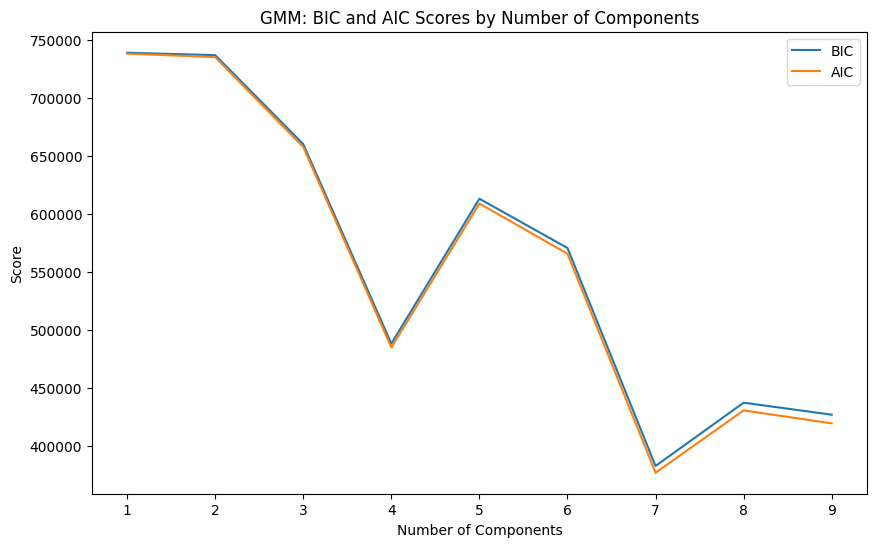

7

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Test a range of cluster numbers
n_components_range = range(1, 10)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(df[features])
    bic_scores.append(gmm.bic(df[features]))
    aic_scores.append(gmm.aic(df[features]))

# Plot the BIC and AIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, label='BIC')
plt.plot(n_components_range, aic_scores, label='AIC')
plt.legend()
plt.title('GMM: BIC and AIC Scores by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.show()

# Identify the number of components with the lowest BIC
optimal_n_components = np.argmin(bic_scores) + 1  # +1 since index starts at 0
optimal_n_components
